In [1]:
import os
if not os.path.exists('ShoeV2_photo'):
    !wget https://www.dropbox.com/s/g6b6gtvmdu0h77x/ShoeV2_photo.zip
    !unzip -q ShoeV2_photo.zip


In [2]:
!pip install -U torch_snippets
from torch_snippets import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'

You should consider upgrading via the '/home/yyr/anaconda3/bin/python -m pip install --upgrade pip' command.


/home/yyr/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


[04/25/21 11:52:25] WARNING  sklearn is not found. Skipping relevant  ]8;id=1619331745.7049863-834722;file:///home/yyr/anaconda3/lib/python3.7/site-packages/torch_snippets/__init__.py\__init__.py]8;;\:<module>:13
                             imports from submodule `sklegos`                                
                             Exception: No module named 'sklego'

In [3]:
def detect_edges(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_gray = cv2.bilateralFilter(img_gray, 5, 50, 50)
    img_gray_edges = cv2.Canny(img_gray, 45, 100)
    img_gray_edges = cv2.bitwise_not(img_gray_edges) # invert black/white
    img_edges = cv2.cvtColor(img_gray_edges, cv2.COLOR_GRAY2RGB)
    return img_edges

IMAGE_SIZE = 256

preprocess = T.Compose([
    T.Lambda(lambda x: torch.Tensor(x.copy()).permute(2, 0, 1).to(device))
])

normalize = lambda x: (x - 127.5)/127.5

class ShoesData(Dataset):
    def __init__(self, items):
        self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, ix):
        f = self.items[ix]
        try: im = read(f, 1)
        except:
            blank = preprocess(Blank(IMAGE_SIZE, IMAGE_SIZE, 3))
            return blank, blank
        edges = detect_edges(im)
        im, edges = resize(im, IMAGE_SIZE), resize(edges, IMAGE_SIZE)
        im, edges = normalize(im), normalize(edges)
        self._draw_color_circles_on_src_img(edges, im)
        im, edges = preprocess(im), preprocess(edges)
        return edges, im

    def _draw_color_circles_on_src_img(self, img_src, img_target):
        non_white_coords = self._get_non_white_coordinates(img_target)
        for center_y, center_x in non_white_coords:
            self._draw_color_circle_on_src_img(img_src, img_target, center_y, center_x)

    def _get_non_white_coordinates(self, img):
        non_white_mask = np.sum(img, axis=-1) < 2.75
        non_white_y, non_white_x = np.nonzero(non_white_mask)
        # randomly sample non-white coordinates
        n_non_white = len(non_white_y)
        n_color_points = min(n_non_white, 300)
        idxs = np.random.choice(n_non_white, n_color_points, replace=False)
        non_white_coords = list(zip(non_white_y[idxs], non_white_x[idxs]))
        return non_white_coords

    def _draw_color_circle_on_src_img(self, img_src, img_target, center_y, center_x):
        assert img_src.shape == img_target.shape, "Image source and target must have same shape."
        y0, y1, x0, x1 = self._get_color_point_bbox_coords(center_y, center_x)
        color = np.mean(img_target[y0:y1, x0:x1], axis=(0, 1))
        img_src[y0:y1, x0:x1] = color

    def _get_color_point_bbox_coords(self, center_y, center_x):
        radius = 2
        y0 = max(0, center_y-radius+1)
        y1 = min(IMAGE_SIZE, center_y+radius)
        x0 = max(0, center_x-radius+1)
        x1 = min(IMAGE_SIZE, center_x+radius)
        return y0, y1, x0, x1

    def choose(self): return self[randint(len(self))]

In [4]:
from sklearn.model_selection import train_test_split
train_items, val_items = train_test_split(Glob('ShoeV2_photo/*.png'), test_size=0.2, random_state=2)
trn_ds, val_ds = ShoesData(train_items), ShoesData(val_items)

trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

inspect(*next(iter(trn_dl)))

                    INFO     4381 files found at    ]8;id=1619331745.7342415-91953;file://<ipython-input-4-2f6e4187209a>\<ipython-input-4-2f6e4187209a>]8;;\:<module>:2
                             ShoeV2_photo/*.png

==================================================================

Tensor  Shape: torch.Size([32, 3, 256, 256])    Min: -1.000     Max: 1.000      Mean: 0.882  
dtype: torch.float32

==================================================================

Tensor  Shape: torch.Size([32, 3, 256, 256])    Min: -1.000     Max: 1.000      Mean: 0.579  
dtype: torch.float32

==================================================================

In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        return self.final(u7)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [6]:
!pip install torch_summary
from torchsummary import summary
generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)

You should consider upgrading via the '/home/yyr/anaconda3/bin/python -m pip install --upgrade pip' command.


In [7]:
def discriminator_train_step(real_src, real_trg, fake_trg):
    #discriminator.train()
    d_optimizer.zero_grad()

    prediction_real = discriminator(real_trg, real_src)
    error_real = criterion_GAN(prediction_real, torch.ones(len(real_src), 1, 16, 16).cuda())
    error_real.backward()

    prediction_fake = discriminator(fake_trg.detach(), real_src)
    error_fake = criterion_GAN(prediction_fake, torch.zeros(len(real_src), 1, 16, 16).cuda())
    error_fake.backward()

    d_optimizer.step()

    return error_real + error_fake

def generator_train_step(real_src, fake_trg):
    #discriminator.train()
    g_optimizer.zero_grad()
    prediction = discriminator(fake_trg, real_src)

    loss_GAN = criterion_GAN(prediction, torch.ones(len(real_src), 1, 16, 16).cuda())
    loss_pixel = criterion_pixelwise(fake_trg, real_trg)
    loss_G = loss_GAN + lambda_pixel * loss_pixel

    loss_G.backward()
    g_optimizer.step()
    return loss_G

denorm = T.Normalize((-1, -1, -1), (2, 2, 2))
def sample_prediction():
    """Saves a generated sample from the validation set"""
    data = next(iter(val_dl))
    real_src, real_trg = data
    fake_trg = generator(real_src)
    img_sample = torch.cat([denorm(real_src[0]), denorm(fake_trg[0]), denorm(real_trg[0])], -1)
    img_sample = img_sample.detach().cpu().permute(1,2,0).numpy()
    show(img_sample, title='Source::Generated::GroundTruth', sz=12)

EPOCH: 1.000	errD: 1.127	errG: 20.277	(139.10s - 13770.53s remaining)


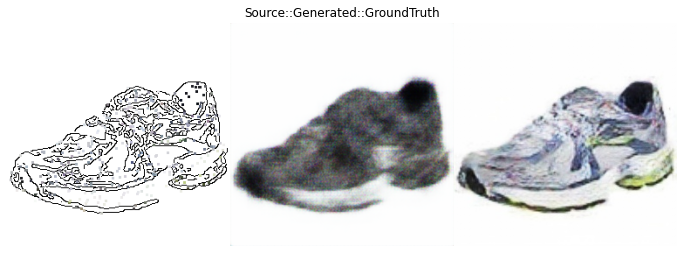

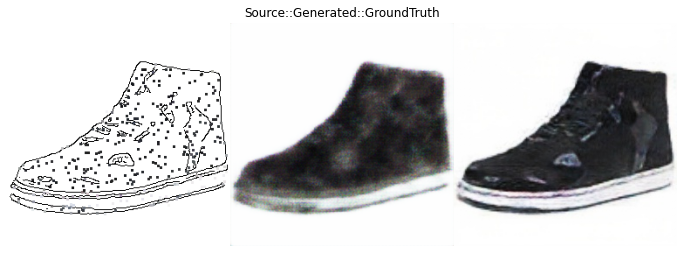

EPOCH: 2.000	errD: 0.550	errG: 10.738	(275.51s - 13499.84s remaining)


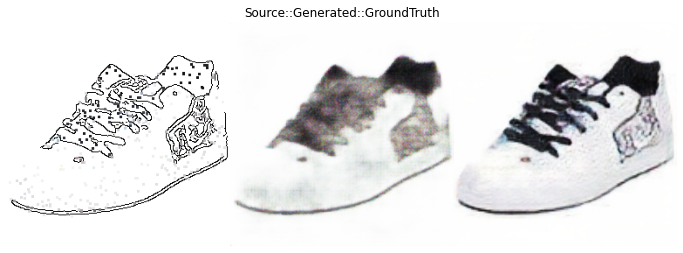

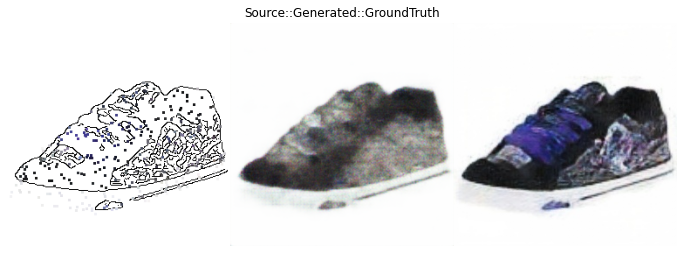

EPOCH: 3.000	errD: 0.498	errG: 8.851	(412.14s - 13325.89s remaining))


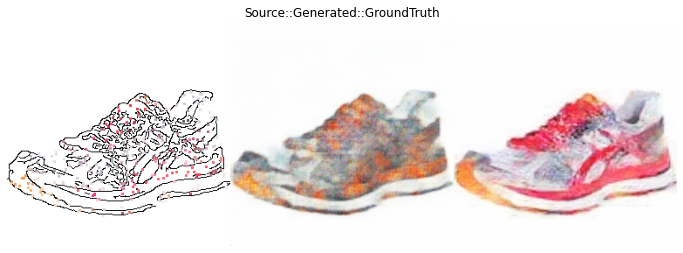

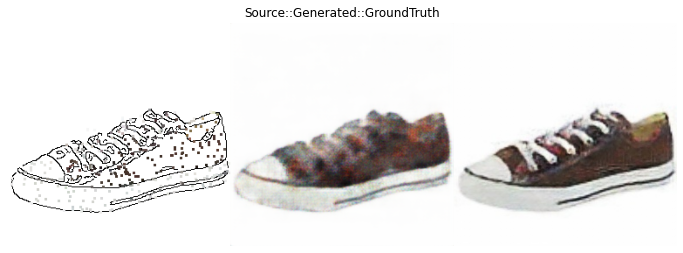

EPOCH: 4.000	errD: 0.517	errG: 7.561	(548.63s - 13167.20s remaining)


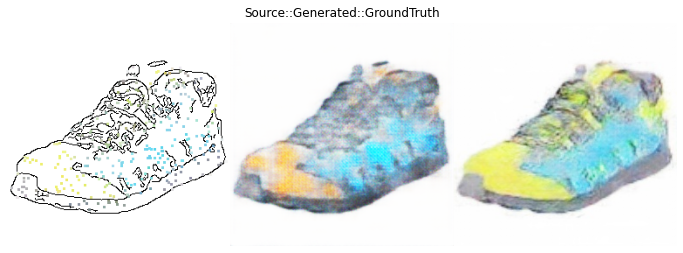

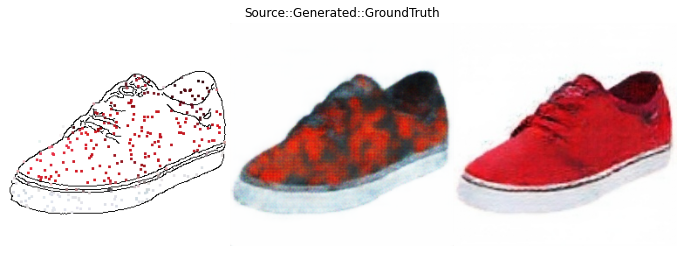

EPOCH: 5.000	errD: 0.516	errG: 6.858	(685.31s - 13020.97s remaining)


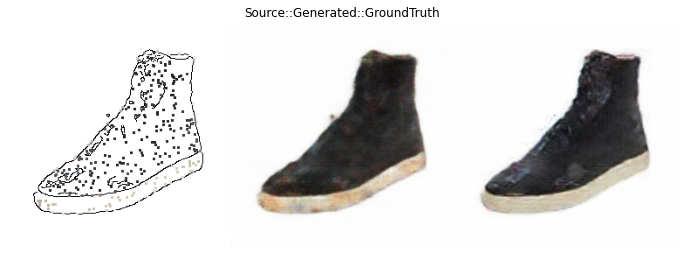

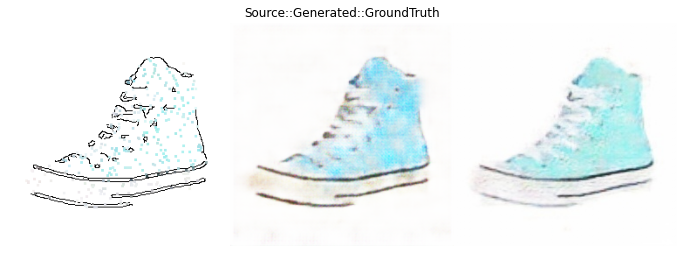

EPOCH: 6.000	errD: 0.511	errG: 6.349	(822.47s - 12885.35s remaining)


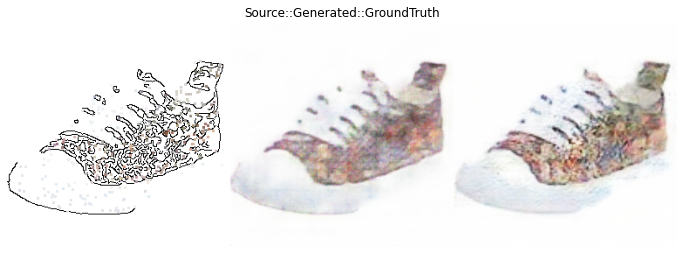

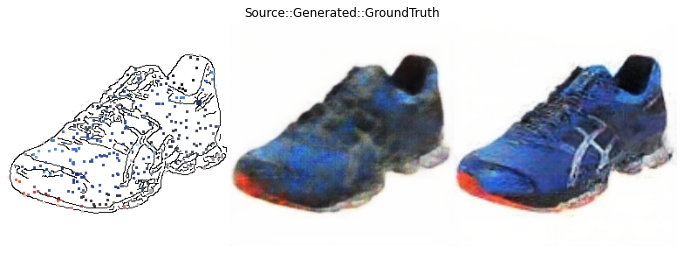

EPOCH: 7.000	errD: 0.475	errG: 5.913	(962.11s - 12782.30s remaining)


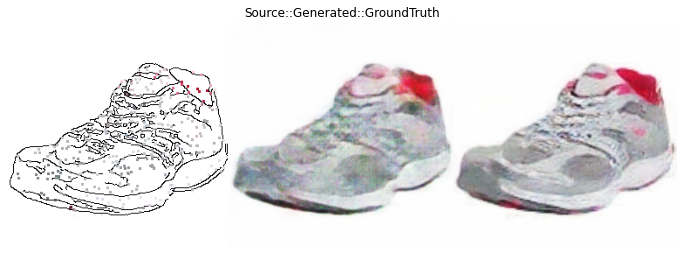

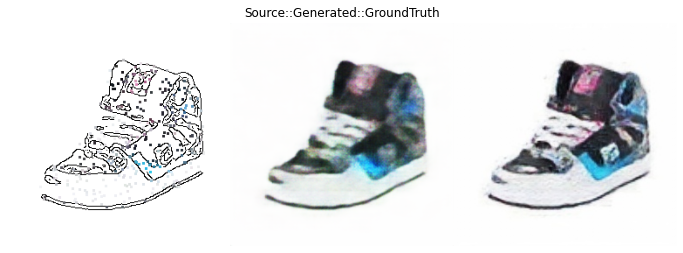

EPOCH: 8.000	errD: 0.492	errG: 5.675	(1098.87s - 12637.03s remaining)


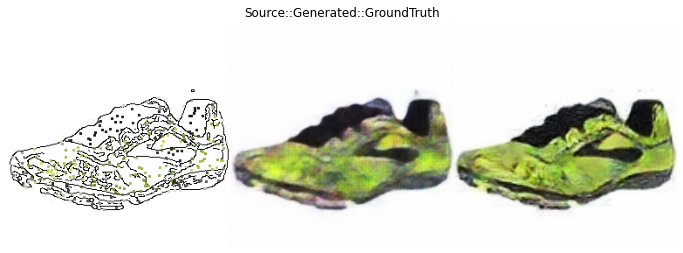

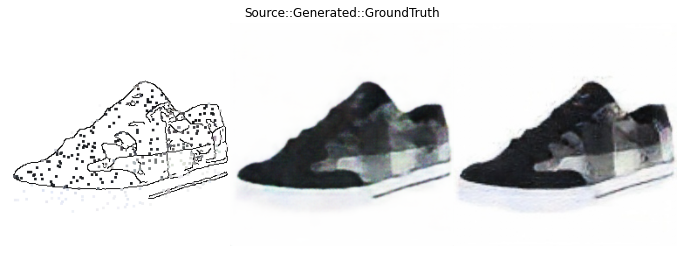

EPOCH: 9.000	errD: 0.482	errG: 5.362	(1235.53s - 12492.55s remaining)


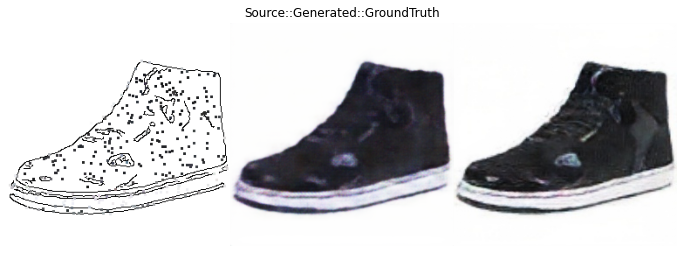

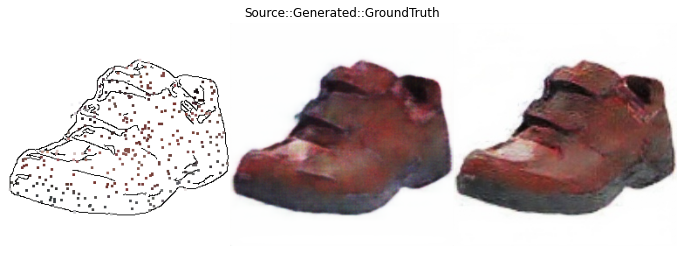

EPOCH: 10.000	errD: 0.471	errG: 5.178	(1378.30s - 12404.70s remaining)


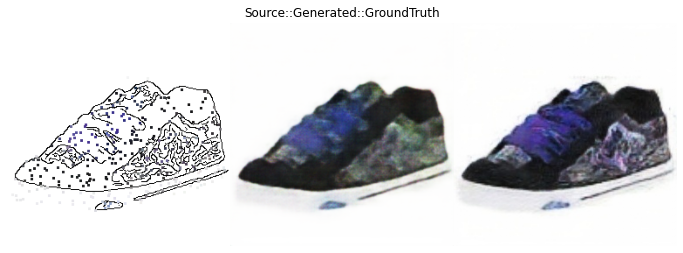

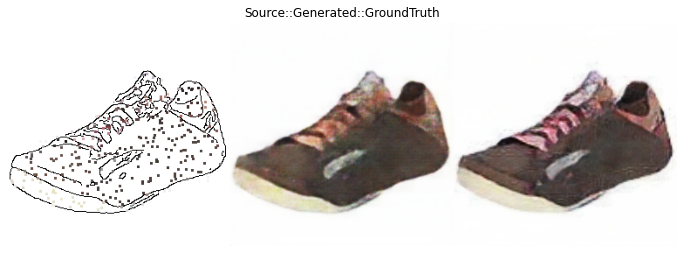

EPOCH: 11.000	errD: 0.505	errG: 4.945	(1529.96s - 12378.76s remaining)


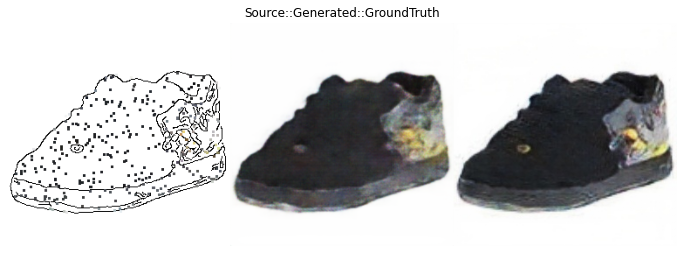

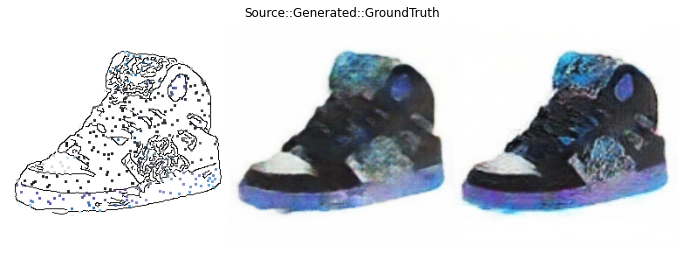

EPOCH: 12.000	errD: 0.451	errG: 4.828	(1683.78s - 12347.69s remaining)


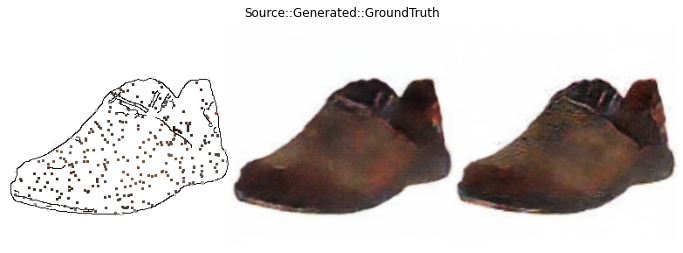

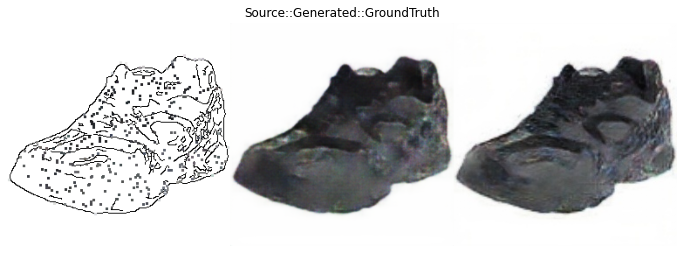

EPOCH: 13.000	errD: 0.469	errG: 4.716	(1839.84s - 12312.80s remaining)


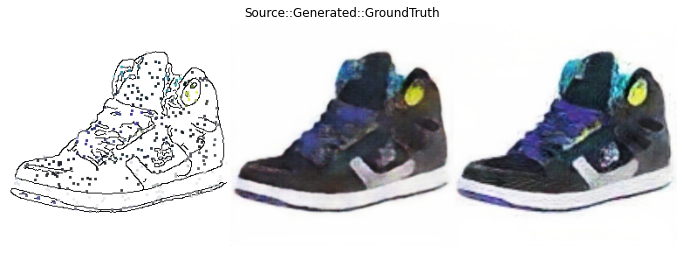

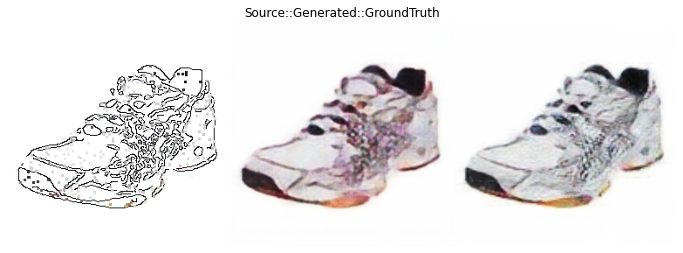

EPOCH: 14.000	errD: 0.477	errG: 4.599	(1994.97s - 12254.83s remaining)


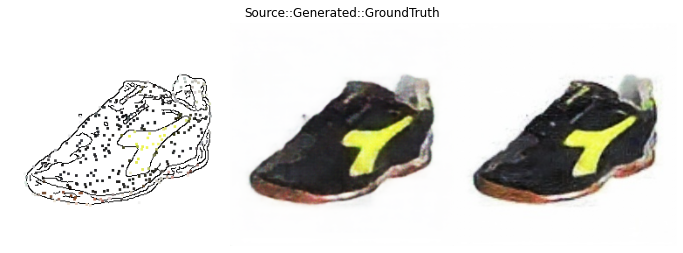

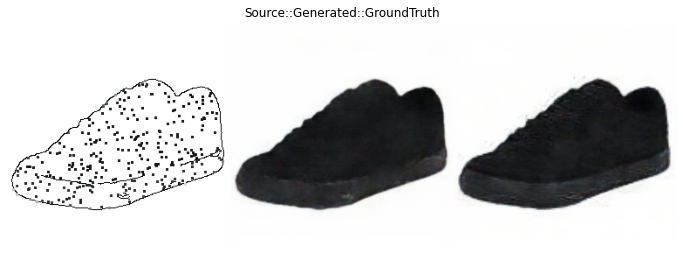

EPOCH: 15.000	errD: 0.492	errG: 4.436	(2150.47s - 12186.00s remaining)


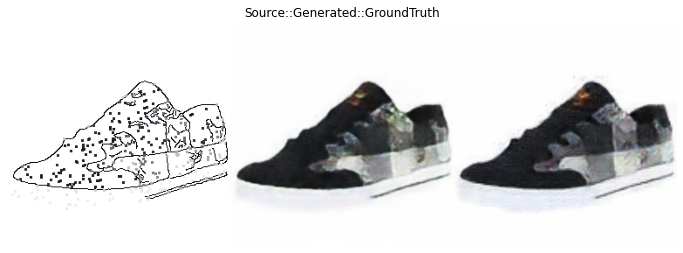

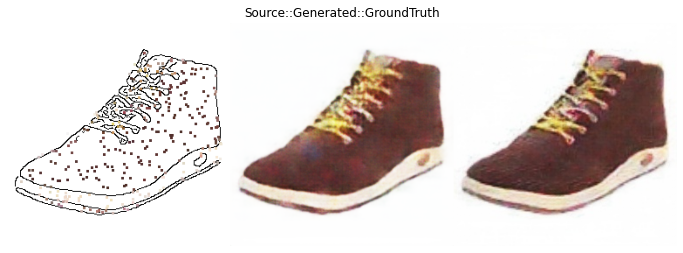

EPOCH: 16.000	errD: 0.490	errG: 4.362	(2301.24s - 12081.50s remaining)


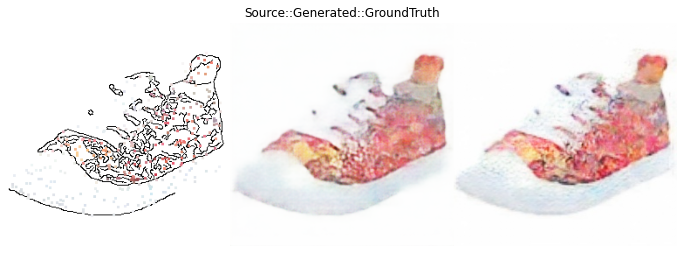

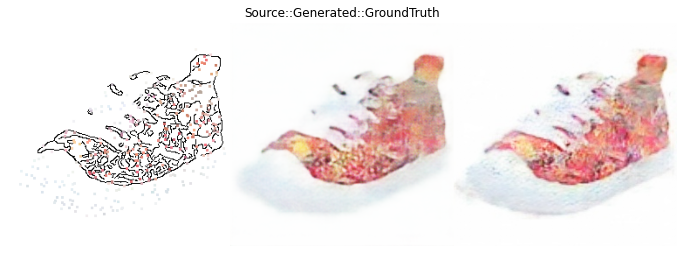

EPOCH: 17.000	errD: 0.519	errG: 4.246	(2457.18s - 11996.81s remaining)


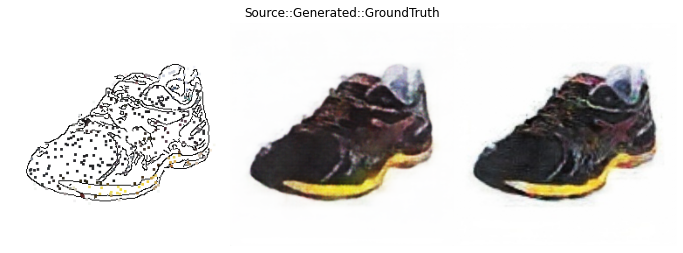

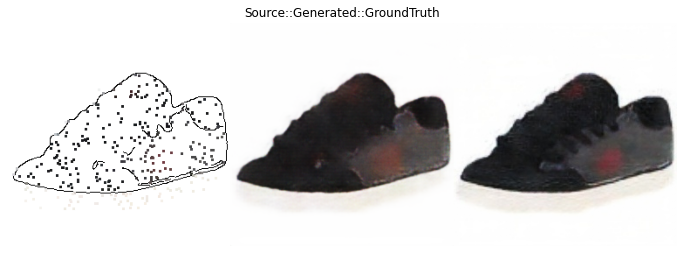

EPOCH: 18.000	errD: 0.489	errG: 4.116	(2613.81s - 11907.36s remaining)


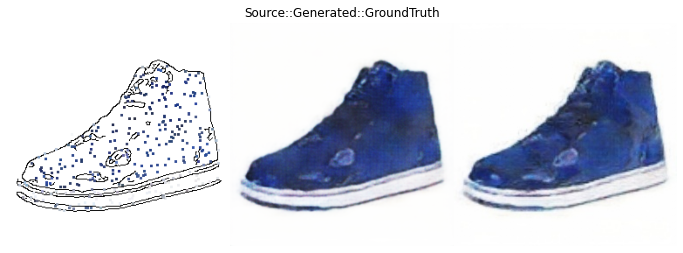

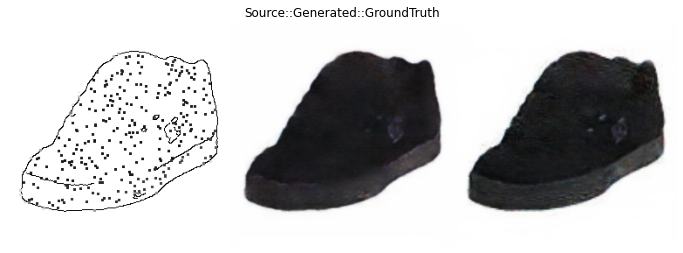

EPOCH: 19.000	errD: 0.522	errG: 4.062	(2789.76s - 11893.21s remaining)


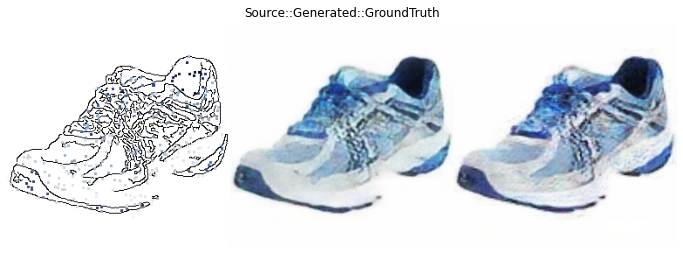

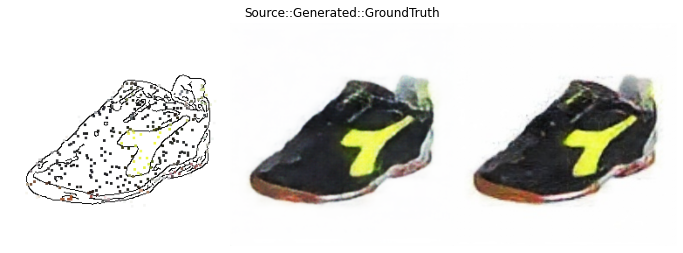

EPOCH: 20.000	errD: 0.501	errG: 4.029	(2966.90s - 11867.59s remaining)


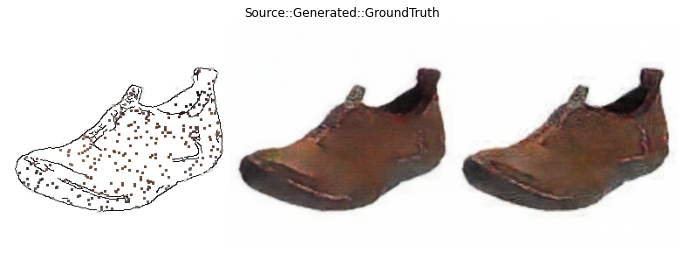

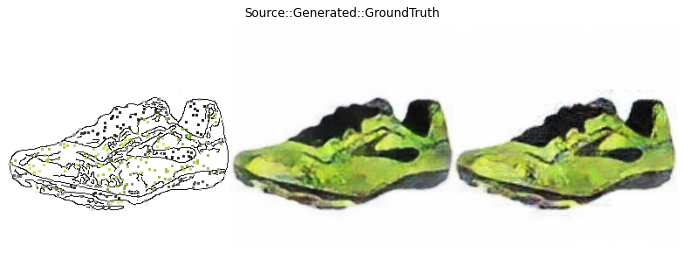

In [9]:
generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

lambda_pixel = 100
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

val_dl = DataLoader(val_ds, batch_size=1, shuffle=True)

epochs = 100
log = Report(epochs)

for epoch in range(epochs):
    N = len(trn_dl)
    for bx, batch in enumerate(trn_dl):
        real_src, real_trg = batch
        fake_trg = generator(real_src)
        
        errD = discriminator_train_step(real_src, real_trg, fake_trg)
        errG = generator_train_step(real_src, fake_trg)
        log.record(pos=epoch+(1+bx)/N, errD=errD.item(), errG=errG.item(), end='\r')

    log.report_avgs(epoch+1)
    [sample_prediction() for _ in range(2)]
